In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier


%matplotlib inline
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20, 10)})

In [2]:
seed = 20548
np.random.seed(seed)

In [5]:
df = pd.read_csv('../input/atmira/Modelar_UH2021.txt', sep="|", decimal = ",")

In [6]:
df.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,1/6/2015 0:00:00,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,1/6/2015 0:00:00,23910,5,C,170.0,No Rotura,6.07,0,0,5241.0,3
2,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,1/6/2015 0:00:00,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,1/6/2015 0:00:00,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0


In [7]:
df.shape

(4045022, 11)

In [8]:
df.dtypes

fecha                 object
id                     int64
visitas                int64
categoria_uno         object
categoria_dos        float64
estado                object
precio               float64
dia_atipico            int64
campaña                int64
antiguedad           float64
unidades_vendidas      int64
dtype: object

Buscamos valores null en las columnas que forman el conjunto de datos.

In [10]:
missing_columns = df.columns[df.isna().any()].tolist()
missing_columns

['categoria_dos', 'precio', 'antiguedad']

Podemos observar que hay tres columnas con valores nulos. Ahora lo que vamos a hacer es ver con cuántos valores nulos cuenta cada una de ellas y de esta manera, decidir de qué forma tratarlos.

In [11]:
missing_data = df.isnull() # Los valores null se representan como True

for column in missing_columns:
    print(column)
    print (missing_data[column].value_counts())
    print("")

categoria_dos
False    4039178
True        5844
Name: categoria_dos, dtype: int64

precio
True     2642911
False    1402111
Name: precio, dtype: int64

antiguedad
False    3170857
True      874165
Name: antiguedad, dtype: int64



Cantidad de valores null por columna:
* `categoria_dos`: 5844
* `precio`: 2642911
* `antiguedad`: 874165

Para tratar los valores nulos de la columna `categoria_dos` al ser un número bajo con respecto a la totalidad de los datos del conjunto a modelar, eliminaremos las filas que contengan dichos valores, pues consideramos que el impacto final no será lo suficientemente notable.

In [12]:
df.dropna(axis=0, subset=["categoria_dos"], inplace = True)

Para tratar los valores nulos de la columna `precio` vamos a realizar lo que se indica en las instrucciones del reto "*Cuando su valor es nulo, ha de ser completado con el precio anterior temporalmente más cercano para cada artículo.*"

Cambiamos el tipo de la columna fecha porque es necesario para realizar comparaciones para rellenar los valores nulos de precio

In [13]:
df['fecha'] = pd.to_datetime(df['fecha'])

In [15]:
# Hay que encontrar la fila con NaN en precio. Coger su id y buscar las filas con el mismo id. Buscar la fecha anterior mas cercana y poner su precio

precio_nan = df[['fecha','id','precio']].where(df['precio'].isnull()).dropna(how='all')
print(precio_nan)
precio_not_nan = df[['fecha','id','precio']].dropna(subset = ["precio"])
print(precio_not_nan)
count = 0

for index, row in precio_nan.iterrows():
    rows_notnan = precio_not_nan.where((precio_not_nan['id'] == row['id']) & (precio_not_nan['fecha'] < row['fecha'])).dropna(how='all')
    if rows_notnan.empty:
        count += 1       
    else:
        mas_reciente = rows_notnan['precio'].iloc[-1]
        df['precio'].iloc[index] = mas_reciente
        
print(count)

             fecha        id  precio
0       2015-01-06   21972.0     NaN
2       2015-01-06   24306.0     NaN
3       2015-01-06   24306.0     NaN
4       2015-01-06   27144.0     NaN
5       2015-01-06   27504.0     NaN
...            ...       ...     ...
4044978 2016-09-30  437904.0     NaN
4044997 2016-09-30  447074.0     NaN
4045011 2016-09-30  452730.0     NaN
4045018 2016-09-30  457422.0     NaN
4045019 2016-09-30  458650.0     NaN

[2638443 rows x 3 columns]
             fecha      id  precio
1       2015-01-06   23910    6.07
6       2015-01-06   30014    6.12
8       2015-01-06   31180    8.05
10      2015-01-06   35732   26.24
14      2015-01-06   40850   14.18
...            ...     ...     ...
4045015 2016-09-30  454950   19.23
4045016 2016-09-30  456982   81.28
4045017 2016-09-30  457416   50.38
4045020 2016-09-30  458660   68.49
4045021 2016-09-30  458660   68.49

[1400735 rows x 3 columns]


KeyboardInterrupt: 

Para tratar los valores nulos de la columna `antiguedad` vamos a reemplazarlos por la media de esta columna:
(La categoria 2 esta relacionada con categoria 1 entonces rellenar por la media segun categoria 1) (Categoria 2 con null, buscar su categoria 1 y encontrar la media de categoria 2 para la categoria 1)

In [16]:
mean_val = int(df['antiguedad'].mean())
mean_val

1011

In [17]:
df['antiguedad'].replace(np.nan, mean_val, inplace=True)

Cambiamos los tipos de ciertas columnas por los tipos correctos.

In [18]:
to_cat = ['categoria_uno', 'categoria_dos', 'estado', 'dia_atipico', 'campaña']
df[to_cat] = df[to_cat].astype('category')
df[['antiguedad']] = df[['antiguedad']].astype('int64')

# Visualizacion de datos

1.   **FECHA**

---

Vamos a visualizar el atributo fecha de diferentes formas para determinar si aporta algún valor a las furturas predicciones.

Aquí podemos visualizar las ventas por meses para poder distinguir si hay una diferencia notoria de ventas entre ellos

<AxesSubplot:xlabel='fecha'>

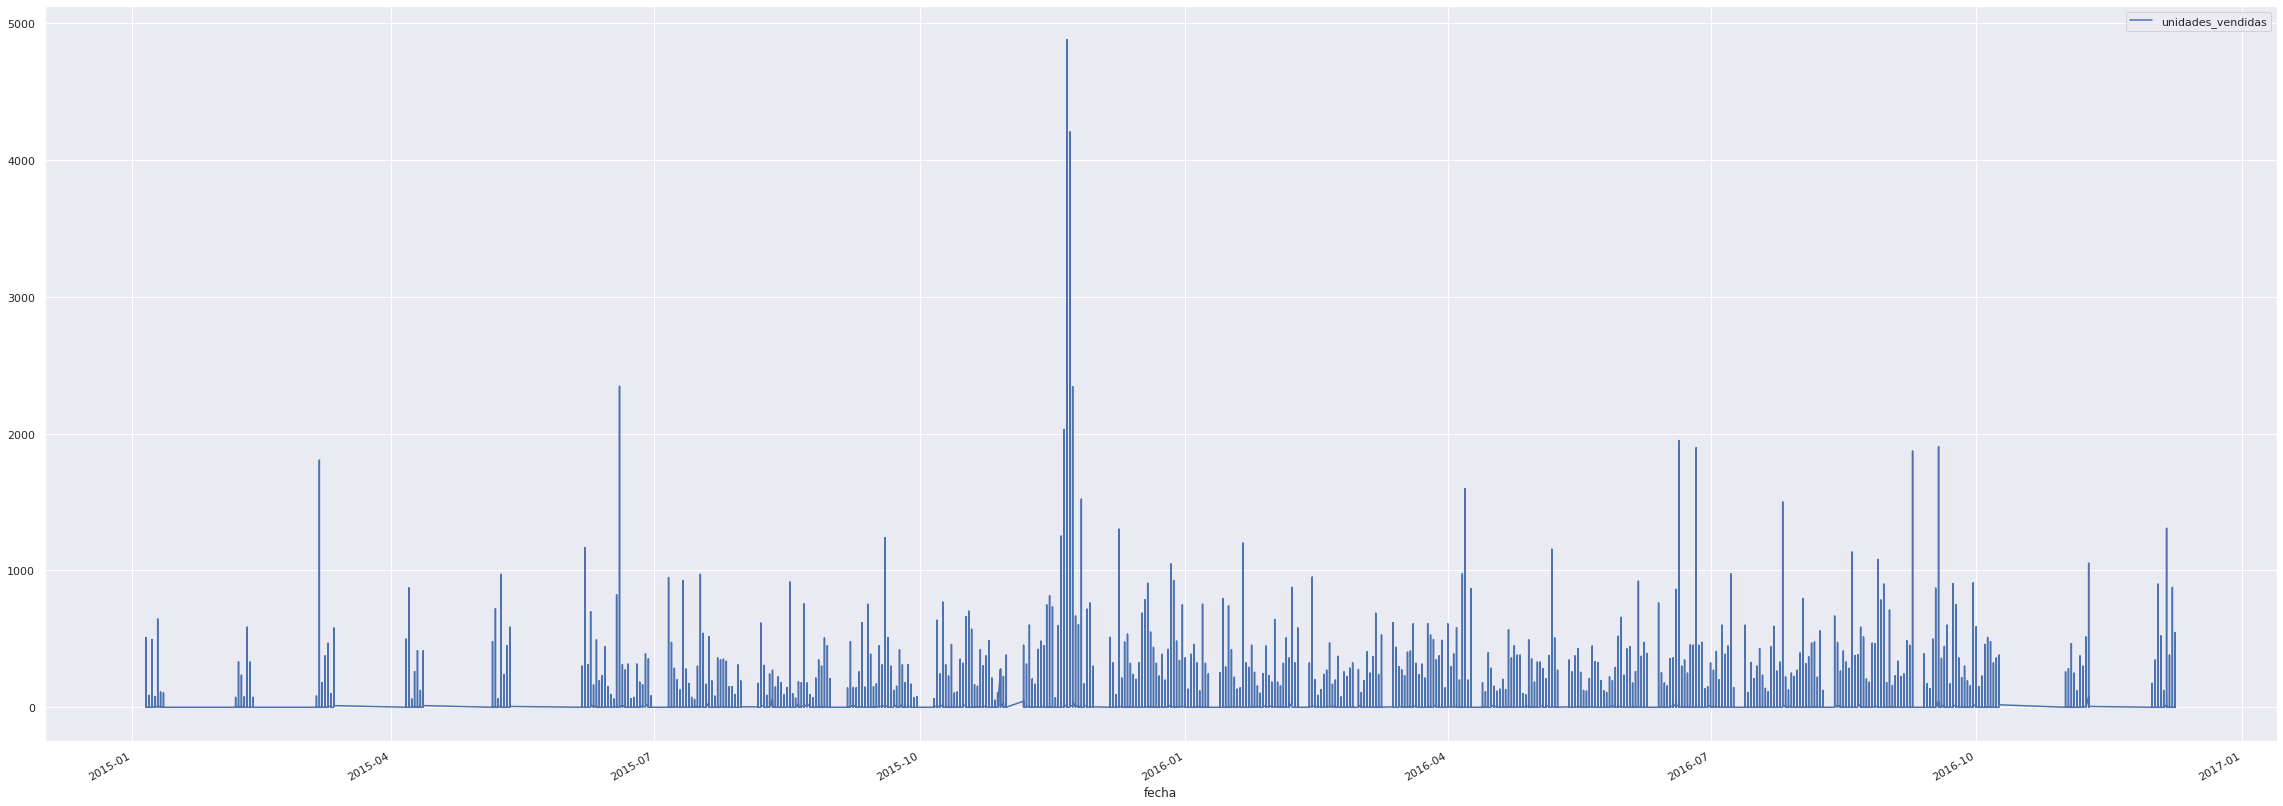

In [19]:
df[['fecha','unidades_vendidas']].set_index('fecha').plot(figsize=(40,15))

(COMENTARIO DE LA GRAFICA RELLENAR CUANDO ESTEN TODOS LOS NULL TRATADOS)

Vamos a transformar el atributo fecha para estudiar las cantidades vendidas en función del día de la semana, si es entre semana o fin de semana, o si es la primera o segunda quincena del mes:

In [20]:
df_days = df.copy()
df_days['dia_semana'] = df_days['fecha'].dt.dayofweek
df_days['fin_de_semana'] = df_days['dia_semana'].apply(lambda x: 1 if (x>3) else 0)

df_days['dia'] = df_days['fecha'].dt.day
df_days['quincena'] = df_days['dia'].apply(lambda x: 1 if (x<15) else 2)

df_days_plot_1 = df_days.groupby('dia_semana').sum()
df_days_plot_1.reset_index(inplace=True)

df_days_plot_2 = df_days.groupby('fin_de_semana').sum()
df_days_plot_2.reset_index(inplace=True)

df_days_plot_3 = df_days.groupby('quincena').sum()
df_days_plot_3.reset_index(inplace=True)

Text(0.5, 1.0, 'Unidades vendidas totales según el día de la semana')

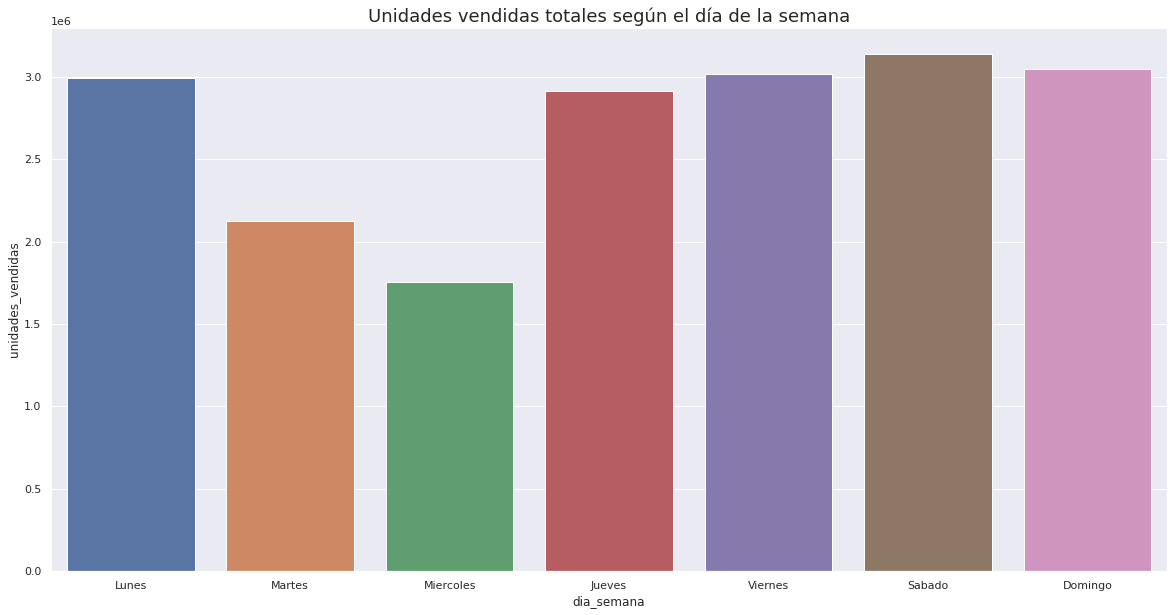

In [21]:
plot_1 = sns.barplot(x='dia_semana', y='unidades_vendidas', data=df_days_plot_1)
plot_1.set_xticklabels(['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo'])
plot_1.set_title('Unidades vendidas totales según el día de la semana', fontsize=18)

(COMENTARIO DE LA GRAFICA RELLENAR CUANDO ESTEN TODOS LOS NULL TRATADOS)

Text(0.5, 1.0, 'Unidades vendidas totales entre semana y en fin de semana')

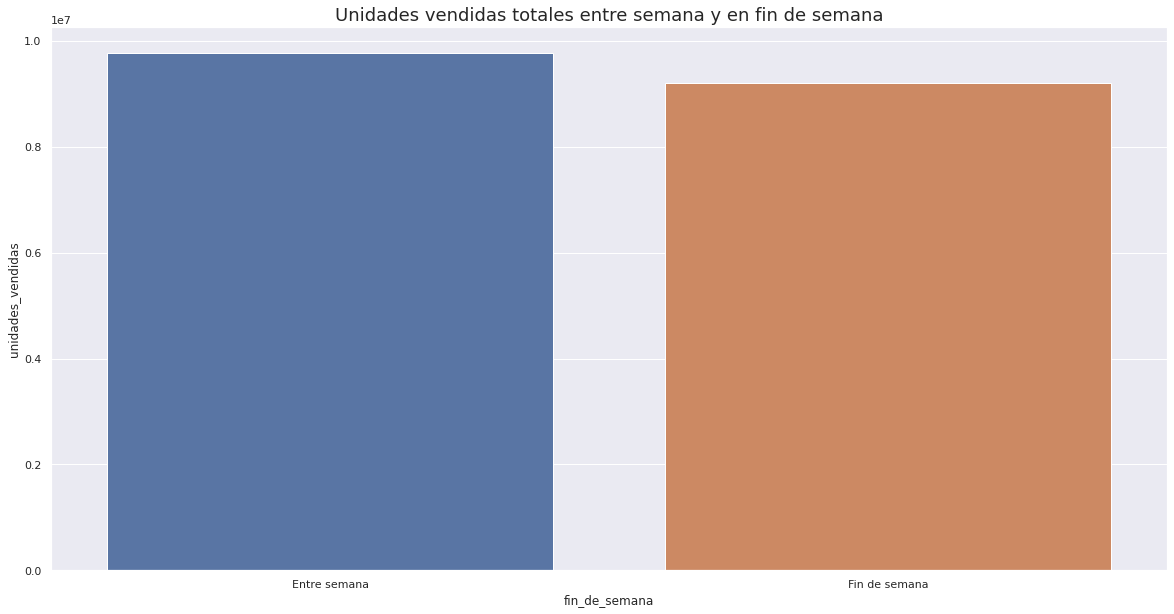

In [22]:
plot_2 = sns.barplot(x='fin_de_semana', y='unidades_vendidas', data=df_days_plot_2)
plot_2.set_xticklabels(['Entre semana','Fin de semana'])
plot_2.set_title('Unidades vendidas totales entre semana y en fin de semana', fontsize=18)

(COMENTARIO DE LA GRAFICA RELLENAR CUANDO ESTEN TODOS LOS NULL TRATADOS)

Text(0.5, 1.0, 'Unidades vendidas totales según la quincena')

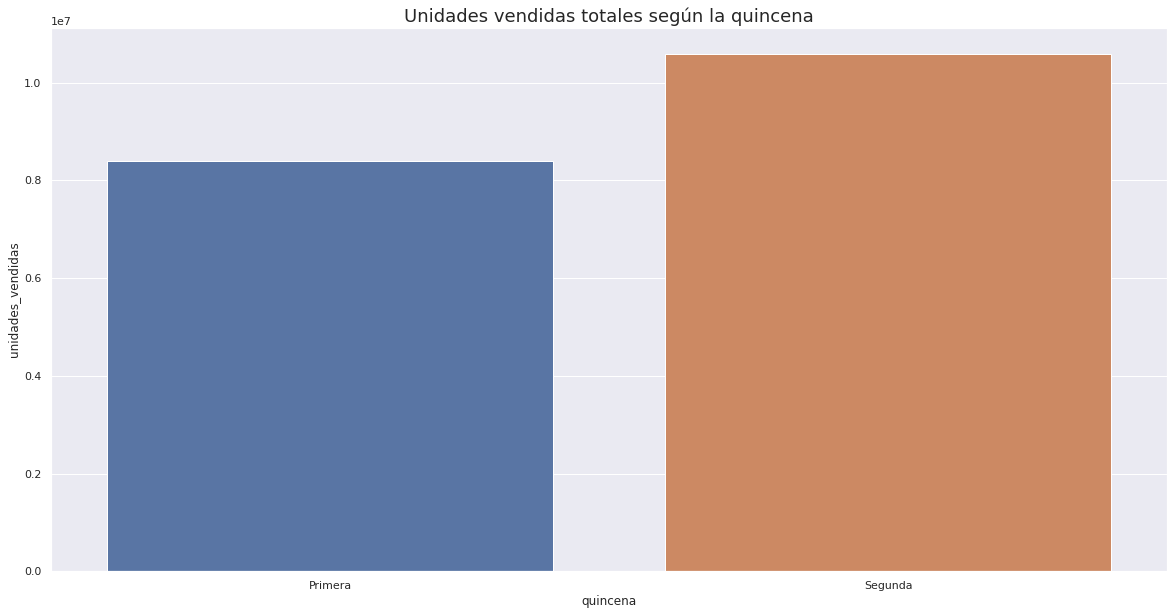

In [23]:
plot_3 = sns.barplot(x='quincena', y='unidades_vendidas', data=df_days_plot_3)
plot_3.set_xticklabels(['Primera','Segunda'])
plot_3.set_title('Unidades vendidas totales según la quincena', fontsize=18)

(COMENTARIO DE LA GRAFICA RELLENAR CUANDO ESTEN TODOS LOS NULL TRATADOS)

2.   **ID**

---

Vamos a revisar los valores únicos del atributo id, ya que si tiene tantos valores únicos como filas tiene nuestro dataset, podríamos eliminarlo ya que no aportaría ningún poder predictivo, pero existe la posibilidad de que el id se refiera a cada producto en concreto y por lo tanto se repita en algunas filas. En tal caso se podría usar este atributo para predecir la cantidad de unidades vendidas:

In [24]:
df['id'].value_counts()

260338    11688
312102     9740
91226      6331
214272     5844
264496     5844
          ...  
326564      487
322464      487
226128      487
336794      487
409400      487
Name: id, Length: 4159, dtype: int64

Se puede observar que el valor id no es único para cada fila ya que por ejemplo, en nuestro data set contamos con 11688 filas con el id 260338. Por lo tanto, vamos a dejar la columna id ya que puede haber productos que en general se vendan más que otros y saber el id nos permite identificar el producto en concreto y quizás facilita la tarea de predicción.

3.   **Variables numéricas (Visitas, Precio, Antigüedad)**

---

Vamos a estudiar el comportamiento de las variables numéricas con las que contamos:

* `Visitas`: número de veces que ha sido visualizada la ficha de un producto dado para un día concreto.
* `Precio`: indica el precio unitario al que se realiza la transacción.
* `Antigüedad`: días transcurridos desde la entrada en catálogo de cada producto.

Vamos a revisar la correlacion entre ellas:

In [25]:
df.corr()

,id,visitas,precio,antiguedad,unidades_vendidas
id,1.000000,0.065424,0.421902,-0.873966,-0.054356
visitas,0.065424,1.000000,0.193868,-0.048956,0.399507
precio,0.421902,0.193868,1.000000,-0.314908,-0.044292
antiguedad,-0.873966,-0.048956,-0.314908,1.000000,0.058778
unidades_vendidas,-0.054356,0.399507,-0.044292,0.058778,1.000000


Vamos a observar los datos de forma mas visual:

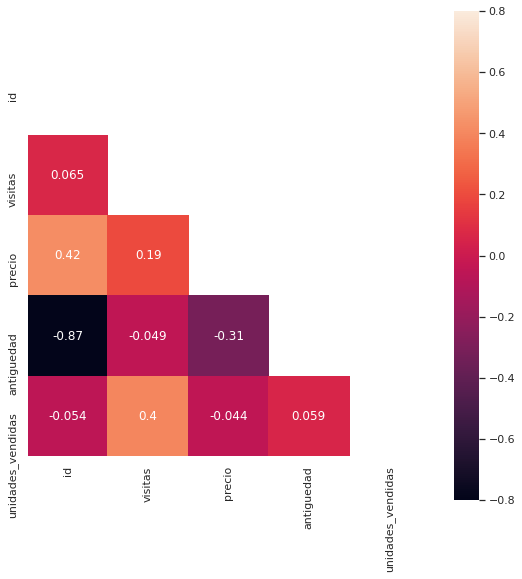

In [26]:
corr = df.corr()

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(9, 9))

    ax = sns.heatmap(corr, mask=mask, vmax=.8, vmin=-.8, annot=True, square=True)

Podemos ver que existe cierta correlacion positiva entre el numero de `visitas` de un producto y las `unidades` que se venden de este. Tambien podemos observar una correlacion negativa entre `antiguedad` y `precio` lo que quiere decir que a medida que la antiguedad de un producto aumenta, su precio se reduce.

Vamos a observar una visión generalizada de la relación entre variables, teniendo en cuenta nuestra variable a predecir. Esto nos ayudará a saber en qué atributos centrarnos y cuál es la manera en la que se relacionan.

In [ ]:
df_correlacion = df.drop(["id", "categoria_dos", "dia_atipico", "campaña"], axis=1)
sns.pairplot(df_correlacion, hue = "unidades_vendidas", diag_kind = "hist", corner = True, palette="viridis")

Podemos observar varias cosas gracias a esta visión general:

*   Existe una tendencia clara entre "precio" y "antigüedad", en la que cuando esta última disminuye, así lo hace también el precio.

*   Podemos observar otra tendencia igual de clara entre las variables "visitas" y "antigüedad", donde a mayor antiguedad de producto, menores visitas encontramos.

Pero lo que realmente nos interesa es cómo estas relaciones afectan a las unidades vendidas, que es nuestra variable a predecir. La conclusión que podemos sacar lógica y que se confirma en los gráficos que observamos arriba es:

*   Cuanto menor es el precio y la antigüedad, las unidades vendidas se incrementan de manera notoria.

Esta relación resulta muy importante a la hora de realizar una predicción. No obstante, respecto a la segunda tendencia que hemos observado antes, existe una relación no tan lógica como la anterior y es que:

*   Cuanto más nuevo y más visitas tenga el producto, no siempre se vende más. De hecho, la mayoría de las unidades vendidas se centran en la franja entre las 0 y las 1000 visitas, siempre y cuando el producto sea novedoso.

Esto también es un factor importante a tener en cuenta en un futuro.





Vamos a estudiar la distribución de las variables numéricas:

In [27]:
def multiple_histogram(data):   
    data_numeric = data[['visitas', 'precio', 'antiguedad']]
    grid = sns.FacetGrid(
        data=pd.melt(data_numeric),
        col="variable", sharey=False, sharex=False, col_wrap=2)
    grid.map(sns.distplot, "value")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

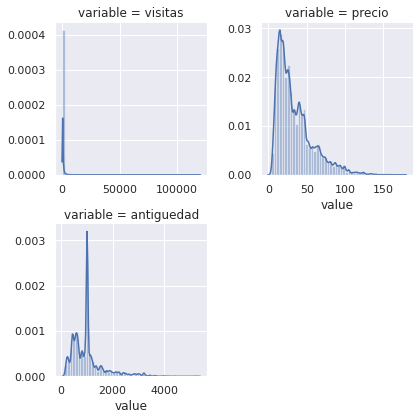

In [28]:
multiple_histogram(df)

Observamos que para la variable `visitas` la gran mayoría de ejemplos se encuentran al principio del rango de valores. Para la variable `precio` podemos observar que según su distribución tiene un sesgo positivo. Con respecto a la variable `antigüedad` observamos que podría tener un sesgo positivo pero observamos un gran pico cuando la antigüedad es aproximadamente 1000. Podría ser interesnate discretizas algunas de estas variables como por ejemplo `precio` y `antiguedad`.

4.   **Categoría uno y Categoría dos**

---

Vamos a estudiar ahora las variables de categoría del producto:
* `categoria_uno`: categoría de producto nivel uno.
* `categoria_dos`: segundo nivel de agrupación para cada producto que precede a la de nivel uno.

Vamos a visualizar la cantidad de unidades vendidas totales según la `categoria_uno` del producto:

<AxesSubplot:xlabel='categoria_uno', ylabel='unidades_vendidas'>

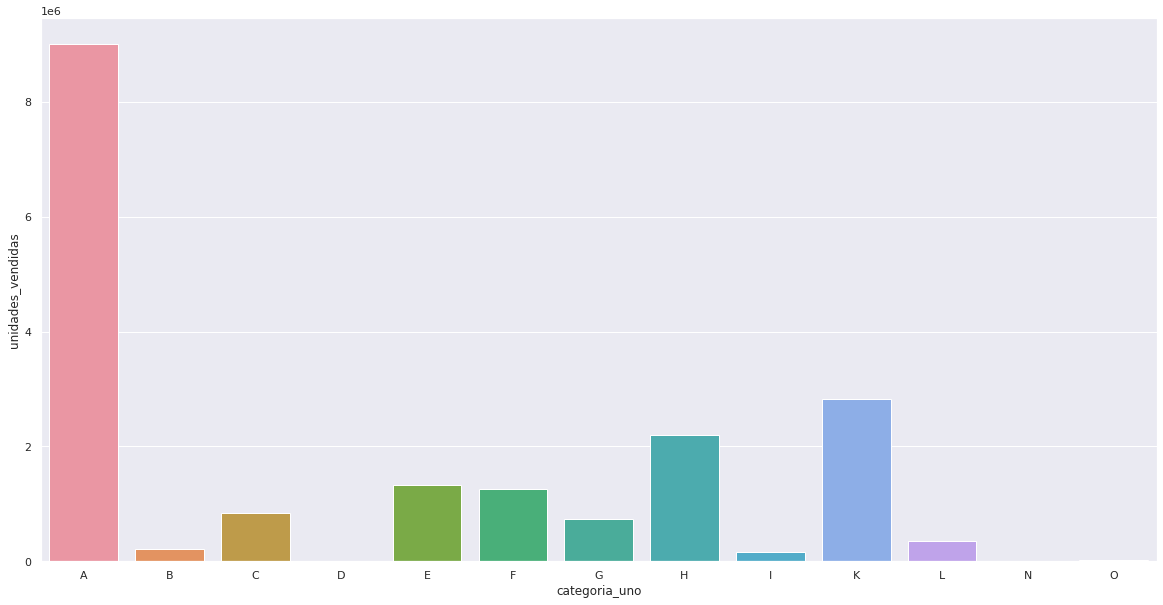

In [29]:
df_2 = df.groupby('categoria_uno').sum()
df_2.reset_index(inplace=True)
sns.barplot(x='categoria_uno', y='unidades_vendidas', data=df_2)

(COMENTAR CUANDO SE TRATEN LOS NULOS)

TARDA MUCHO

In [ ]:
sns.barplot(x="categoria_uno", y="unidades_vendidas", data=df, palette=sns.color_palette("summer", 7))

(COMENTAR CUANDO SE TRATEN LOS NULOS Y VER SI SE DEJA ESTA O LA OTRA)

(VER QUE HACER CON CATEGORIA DOS)

In [32]:
df.drop(['categoria_dos'], axis=1, inplace=True)

5.   **ESTADO**

---





Pasamos a estudiar el comportamiento de la variable `estado`: situación en la que se encuentra el producto. 

Esta variable toma 3 posibles valores:

* Rotura: no hay stock físico disponible para servir en nuestros almacenes.
* Tránsito: no hay stock físico en nuestros almacenes, pero está pendiente de entrega inminente desde proveedor.
* No Rotura: hay stock físico disponible en nuestros almacenes.

In [33]:
df_estado = df.groupby('estado').sum()
df_estado.reset_index(inplace=True)

<AxesSubplot:xlabel='estado', ylabel='unidades_vendidas'>

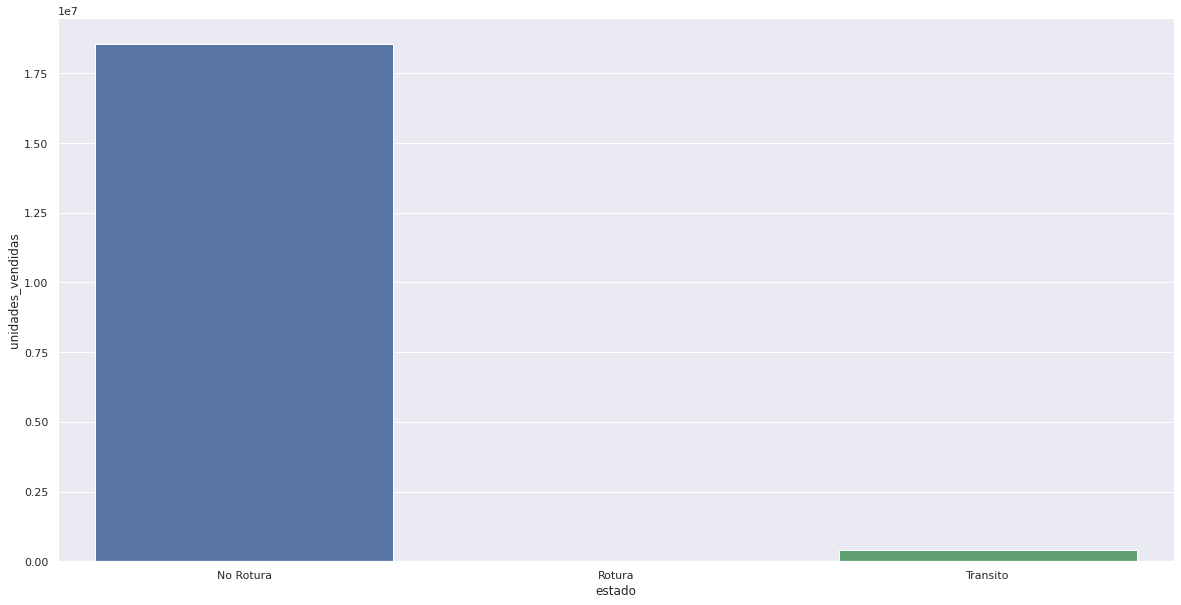

In [34]:
sns.barplot(x='estado', y='unidades_vendidas', data=df_estado)

VER SI SE DROPEA

Podemos observar que la lógica se aplica en esta variable. Observamos que la mayoría de productos vendidos tienen el estado No Rotura que significa que hay stock en los almacenes. Vemos que no se venden tantos productos con es estado Tránsito y no se venden productos con el estado Rotura que significa que son productos de los cuales no hay stock. Podemos deducir que la gente tiende a comprar más los productos que ya se encuentran en los almacenes de la empresa, y apenas compran productos en los cuales hay que esperar a que el stock llegue.

6. **DIA_ATIPICO**

---



Vamos a estudiar la variable `dia_atipico` que toma los siguientes valores:
* 0: si estamos fuera de fechas con comportamiento atípico.
* 1: si estamos en un periodo con una demanda más alta de lo habitual.
* -1: si estamos en un periodo con una demanda más baja de lo habitual.

In [35]:
df_atipico = df.groupby('dia_atipico').sum()
df_atipico.reset_index(inplace=True)

<AxesSubplot:xlabel='dia_atipico', ylabel='unidades_vendidas'>

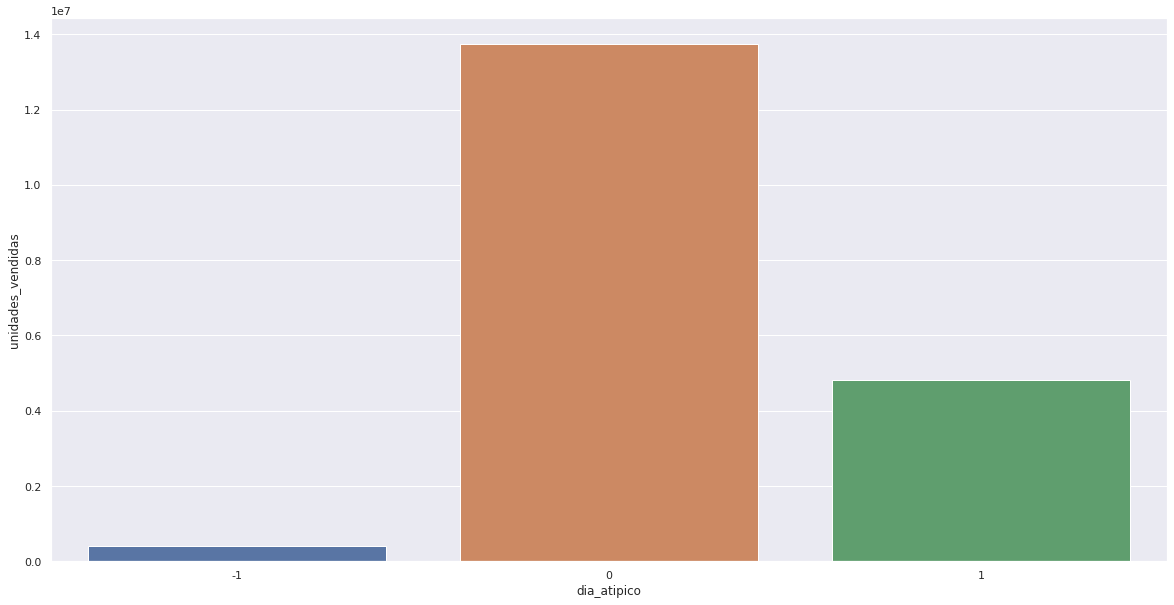

In [36]:
sns.barplot(x='dia_atipico', y='unidades_vendidas', data=df_atipico)

Vemos que generalmente se venden más productos fuera de fechas con comportamiento atípico. Cuando nos encontramos en fechas con un periodo de ventas más bajo que el habitual se venden menos productos y ocurre lo contrario cuando nos encontramos en la situación opuesta.

7. **CAMPAÑA**
---

Estudiamos el comportamiento de la variable `campaña`: esta variable nos indica para las campañas principales, si el producto estaba en promoción o no en una fecha determinada.

In [37]:
df_camp = df.groupby('campaña').sum()
df_camp.reset_index(inplace=True)

<AxesSubplot:xlabel='campaña', ylabel='unidades_vendidas'>

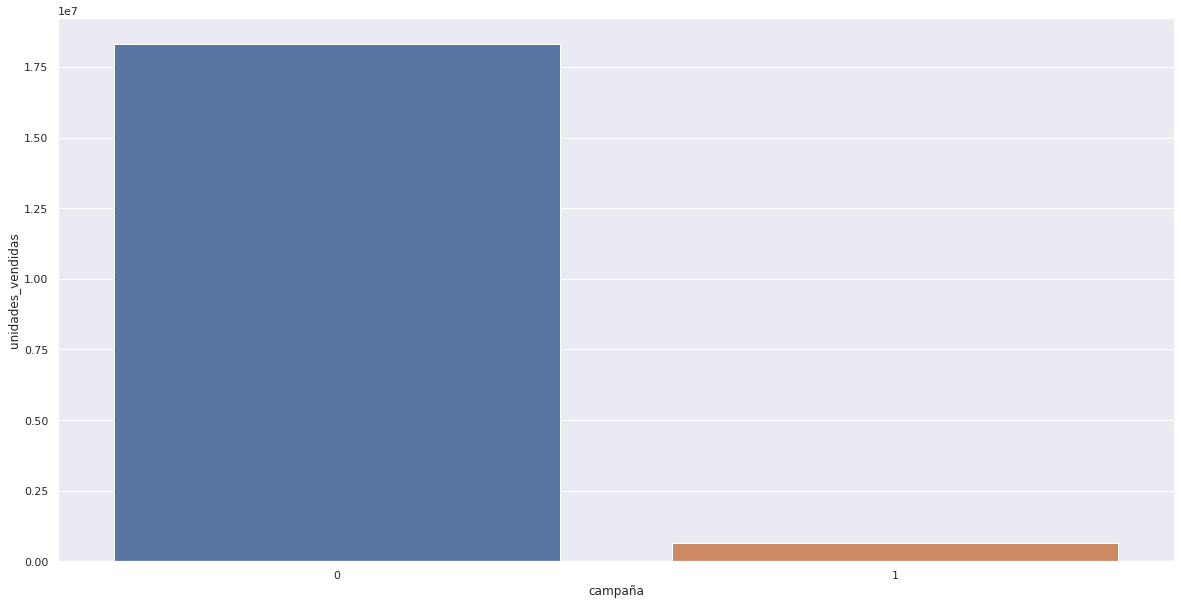

In [38]:
sns.barplot(x='campaña', y='unidades_vendidas', data=df_camp)

(NI IDEA)

# Dividir dataset

Dividir el dataset en X e y

In [39]:
#QUITAR ESTO LUEGO
df.dropna(inplace=True)

In [40]:
(X, y) = (df.drop('unidades_vendidas', axis=1), df['unidades_vendidas'])

In [41]:
X.sample(5)

,fecha,id,visitas,categoria_uno,estado,precio,dia_atipico,campaña,antiguedad
1944422,2016-01-21,147500,32,H,No Rotura,8.25,0,0,1895
432200,2015-07-23,101920,74,G,No Rotura,13.29,0,0,2752
800042,2015-05-09,247182,38,A,No Rotura,10.17,0,0,1005
1458781,2015-11-23,322678,67,A,No Rotura,22.99,1,0,602
3810241,2016-02-09,336698,400,H,No Rotura,64.46,0,0,533


In [42]:
y.sample(5)

2024774    3
83125      3
219580     6
2718736    3
2595127    3
Name: unidades_vendidas, dtype: int64

Dividimos en train/test

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.7, random_state=seed)

In [46]:
X_train.sample(5)

,fecha,id,visitas,categoria_uno,estado,precio,dia_atipico,campaña,antiguedad
2921458,2016-05-18,336566,2305,H,No Rotura,66.97,0,0,1011
1385128,2015-11-14,339374,13,A,No Rotura,24.68,0,0,501
1580146,2015-08-12,211682,15,A,No Rotura,19.15,-1,0,1168
2414844,2016-03-18,336756,80,F,No Rotura,10.71,0,0,532
2729375,2016-04-25,319780,4020,K,No Rotura,28.73,0,0,617


In [49]:
y_train.sample(5)

282528     39
744496      6
3170478     6
2049620    12
1267620    12
Name: unidades_vendidas, dtype: int64

In [50]:
X_test.sample(5)

,fecha,id,visitas,categoria_uno,estado,precio,dia_atipico,campaña,antiguedad
2044566,2016-02-02,180590,585,A,No Rotura,41.91,0,0,1516
2146610,2016-02-14,279310,95,A,No Rotura,9.52,0,0,819
1722957,2015-12-25,278028,56,F,No Rotura,23.24,-1,0,827
1464825,2015-11-24,260784,60,A,No Rotura,47.27,1,0,943
2389897,2016-03-15,336604,495,H,No Rotura,45.35,0,0,533


In [51]:
y_test.sample(5)

1790279     3
2459481     9
523409     33
1125148     6
1983779     6
Name: unidades_vendidas, dtype: int64

# Transformadores

In [52]:
col_transform = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), [5]), ('ordinal', OrdinalEncoder(), [3, 4]), ('discretizer', KBinsDiscretizer(strategy='uniform'), [6])])

In [53]:
class DatesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        X_['dia_semana'] = X_['fecha'].dt.dayofweek # el rango de dayofweek es [0-6]
        X_['fin_de_semana'] = X_['dia_semana'].apply(lambda x: 1 if (x>3)  else 0) # 0-->no fin de semana, 1-->fin de semana
        X_['dia'] = X_['fecha'].dt.day
        X_['quincena'] = X_['dia'].apply(lambda x: 1 if (x<15) else 2)
        X_.drop(['fecha'], axis=1)
        X_.drop(['dia'], axis=1)
        
        return X_

# Random forest

In [55]:
def create_param_grid(**kwargs):
    """Create a grid of hyperparameters mapped to their values."""
    return kwargs

In [58]:
forest_pipe = make_pipeline(
    DatesTransformer(),
    col_transform, 
    RandomForestRegressor()
) 

In [ ]:
# Initialize the number of estimators
n_estimators = [50, 100]

# Initialize the criteria
criterion = ["mse", "mae"]

# Initialize the maximum number of features
max_features = ["sqrt", "log2"]

# Initialize the grid of hyperparameters for Random Forests
forest_param_grid = create_param_grid(
    randomforestregressor__n_estimators=n_estimators, randomforestregressor__criterion=criterion, randomforestregressor__max_features=max_features)

# Configure the Grid Search for Random Forests
forest_search_model = GridSearchCV(forest_pipe, forest_param_grid, scoring='neg_mean_absolute_error', cv=3)

# Fit the parameters of the Grid Search
# for Random Forests to the training dataset
forest_search_clf = forest_search_model.fit(X_train, y_train)

In [ ]:
forest_search_clf.best_params_

# kNN

In [54]:
knn_pipe = make_pipeline(
    DatesTransformer(),
    col_transform, 
    KNeighborsRegressor()
) 

In [56]:
n_neighbors = [10,20]
weights = ["uniform", "distance"]

knn_param_grid = create_param_grid(kneighborsregressor__n_neighbors=n_neighbors, kneighborsregressor__weights=weights)

In [57]:
knn_search_model = GridSearchCV(knn_pipe, knn_param_grid, scoring='neg_mean_absolute_error', cv=3)

In [ ]:
knn_search_clf = knn_search_model.fit(X_train, y_train)

In [ ]:
knn_search_clf.best_params_

# Redes neuronales

Vamos a crear diferentes estructuras de red neuronal para evaluar su puntuación y seleccionar cuál de todos los métodos es el más preciso

In [59]:
def create_network():
    model1 = Sequential()
    model1.add(Dense(12, input_dim=8, activation='relu'))
    model1.add(Dense(1, activation='relu'))
    opt = SGD(lr=0.01, momentum=0.9)
    model1.compile(loss='mean_squared_error', optimizer = opt)

# Primero hacer una funcion que crea un model de red neuronal, una funcion que haga lo de las lineas anteriores.
# Despues crear un neural_network = KerasClassifier(build_fn=la_funcion, epochs=10, batch_size=100, verbose=0)
# cross_val_score(neural_network, jfhvgbei, hrwgfewrk, cv=4)

In [60]:
def create_model2():
    model2 = Sequential()
    model2.add(Dense(12, input_dim=8, activation='relu'))
    model2.add(Dense(8, activation='relu'))
    model2.add(Dense(1, activation='relu'))
    opt = SGD(lr=0.01, momentum=0.9)
    model2.compile(loss='mean_squared_error', optimizer = opt)

In [61]:
def create_model3():
    model3 = Sequential()
    model3.add(Dense(12, input_dim=8, activation='relu'))
    model3.add(Dense(8, activation='relu'))
    model3.add(Dense(4, activation='relu'))
    model3.add(Dense(1, activation='relu'))
    opt = SGD(lr=0.01, momentum=0.9)
    model3.compile(loss='mean_squared_error', optimizer = opt)